<a href="https://colab.research.google.com/github/mona-jha/Machine-Learning-II/blob/main/problem-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1><b>Assignment-1(ML2)<b>
<h2> Name : Mona Kumari <br>
Roll No. :<b> CS2311</b>



---



 **Problems on Variational Auto-Encoder**

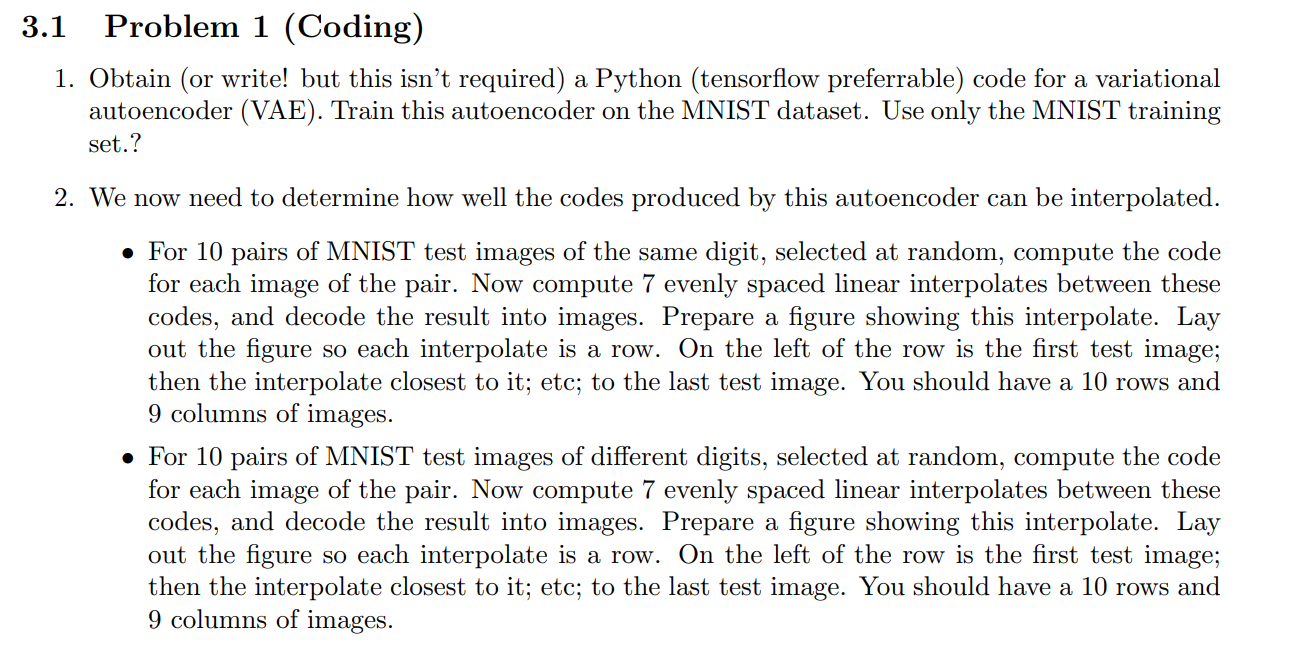

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)


latent_dims = 2
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3

# weight of the regularizer
variational_beta = 1
use_gpu = True


MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

# create training set and train dataloaders
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# create test set and test dataloaders
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16251602.65it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 524844.54it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4388645.82it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10084980.82it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



VAE Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In [ ]:
# encoder module
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity

        # ((n - k + 2p) // s + 1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out:[128 x c x 14 x 14]
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: [128 x 2*c x 7 x 7]

        # (B, C, H, W)
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) #mean
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) #log (variance)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

# decoder modeule
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        # ((n-1) * s + k - 2p)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):

        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss

        return x

# vae model
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):

        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):

        # the reparameterization trick
        if self.training:

            std = logvar.mul(0.5).exp_()

            # sampling from N(0, 1) ---- standard normal
            eps = torch.empty_like(std).normal_()

            # z = e * sigma + mean
            return eps.mul(std).add_(mu)

        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.

    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

# creating model
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)


In [ ]:
# x = torch.rand(128, 2, 3, 4, 7, 8)
# # z = x.view(128, 6, -1)
# print(z.shape)

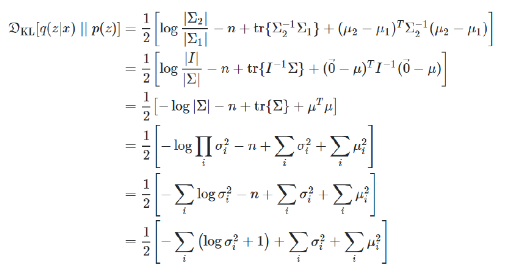


# [Details of ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d)

In [ ]:
# Learn about ConvTranspose2d

import torch
import torch.nn as nn

# (B, C, H, W)
m = nn.ConvTranspose2d(in_channels = 16, out_channels = 33, kernel_size = 3, stride=2, padding = 1)

# m = nn.ConvTranspose2d(16, 33, 5, 2, 2)

# ((n-1) * s + k - 2p)

input = torch.randn(20, 16, 50, 100)

output = m(input)
print(input.shape)
print(output.shape)

torch.Size([20, 16, 50, 100])
torch.Size([20, 33, 99, 199])


Train VAE
--------

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

torch.save(vae.state_dict(), 'best_vae.pt')

Training ...
Epoch [1 / 50] average reconstruction error: 23713.408470
Epoch [2 / 50] average reconstruction error: 21381.544110
Epoch [3 / 50] average reconstruction error: 20717.226867
Epoch [4 / 50] average reconstruction error: 20352.488256
Epoch [5 / 50] average reconstruction error: 20132.797650
Epoch [6 / 50] average reconstruction error: 19987.724360
Epoch [7 / 50] average reconstruction error: 19894.610914
Epoch [8 / 50] average reconstruction error: 19804.912413
Epoch [9 / 50] average reconstruction error: 19738.950624
Epoch [10 / 50] average reconstruction error: 19669.520897
Epoch [11 / 50] average reconstruction error: 19618.932438
Epoch [12 / 50] average reconstruction error: 19574.585738
Epoch [13 / 50] average reconstruction error: 19524.702244
Epoch [14 / 50] average reconstruction error: 19486.787286
Epoch [15 / 50] average reconstruction error: 19449.168450
Epoch [16 / 50] average reconstruction error: 19410.671125
Epoch [17 / 50] average reconstruction error: 19375.

Plot Training Curve
--------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


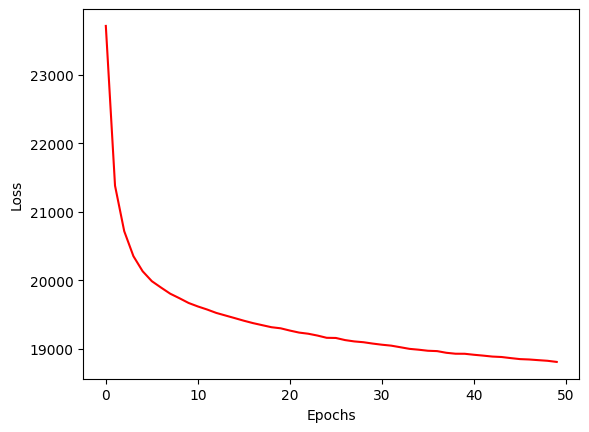

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_avg, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
vae.load_state_dict(torch.load('/content/best_vae.pt'))
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
  with torch.no_grad():

    image_batch = image_batch.to(device)

    # vae reconstruction
    image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

    # reconstruction error
    loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

    test_loss_avg += loss.item()
    num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

<ipython-input-10-6b0e2b7f5815>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('/content/best_vae.pt'))


average reconstruction error: 19195.520329


Visualize Reconstructions
--------------------------

images  torch.Size([128, 1, 28, 28])
Original images


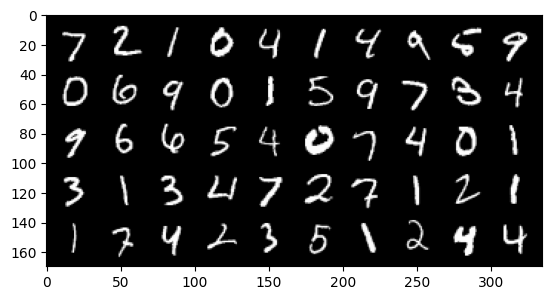

VAE reconstruction:


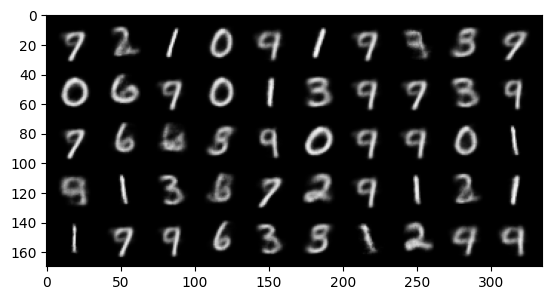

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # H, W, C

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[0:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

for images, labels in test_dataloader:

  # First visualise the original images
  print("images ", images.shape)
  print('Original images')
  z = torchvision.utils.make_grid(images[0:50],10,5)
  show_image(z)
  plt.show()

  # Reconstruct and visualise the images using the vae
  print('VAE reconstruction:')
  visualise_output(images, vae)

  break

# Interpolate in Latent Space

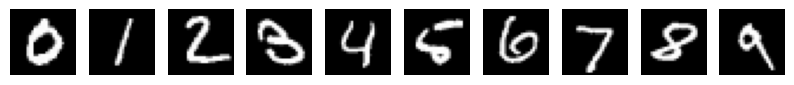

In [ ]:
# Function to visualize interpolations
def visualize_interpolations(interpolations, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i, row in enumerate(interpolations):
        for j, img in enumerate(row):
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.show()

# Visualize digits 0-9
def visualize_digits_0_9(test_dataset):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i in range(10):
        for img, label in test_dataset:
            if label == i:
                axes[i].imshow(img.squeeze(), cmap='gray')
                axes[i].axis('off')
                break
    plt.show()

visualize_digits_0_9(test_dataset)

In [ ]:
def interpolate_images(vae, img1, img2, num_interpolations, device):
    vae.eval()
    with torch.no_grad():
        img1 = img1.to(device).unsqueeze(0)
        img2 = img2.to(device).unsqueeze(0)
        mu1, logvar1 = vae.encoder(img1)
        mu2, logvar2 = vae.encoder(img2)
        interpolations = []
        for alpha in np.linspace(0, 1, num_interpolations):
            z = mu1 * (1 - alpha) + mu2 * alpha
            recon = vae.decoder(z)
            interpolations.append(recon.cpu().squeeze().numpy())
        return interpolations


In [ ]:
def visualize_interpolations(interpolations, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i, row in enumerate(interpolations):
        for j, img in enumerate(row):
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.show()

Generate and visualize interpolations for same digit pairs

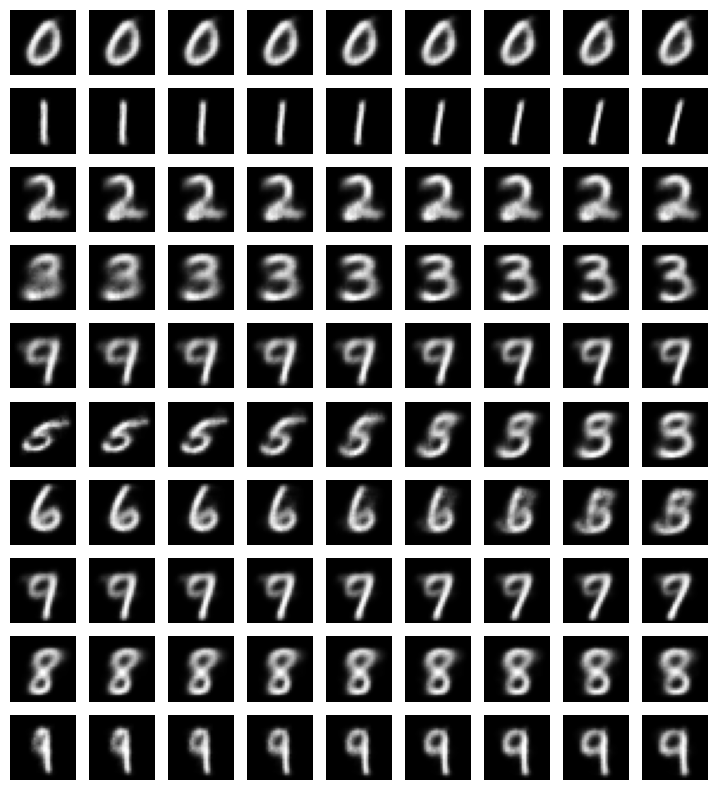

In [ ]:

def generate_same_digit_interpolations(test_dataset, vae, num_interpolations, device):
    same_digit_interpolations = []
    for digit in range(10):
        digit_images = [img for img, label in test_dataset if label == digit]
        # Convert digit_images to a NumPy array
        digit_images = np.array(digit_images)
        # Get the indices instead of the images
        idx1, idx2 = np.random.choice(len(digit_images), 2, replace=False)
        # Select the images based on the indices
        img1 = torch.from_numpy(digit_images[idx1])
        img2 = torch.from_numpy(digit_images[idx2])
        interpolations = interpolate_images(vae, img1, img2, num_interpolations, device)
        same_digit_interpolations.append(interpolations)
    return same_digit_interpolations

same_digit_interpolations = generate_same_digit_interpolations(test_dataset, vae, 9, device)
visualize_interpolations(same_digit_interpolations, 10, 9)

Generate and visualize interpolations for different digit pairs

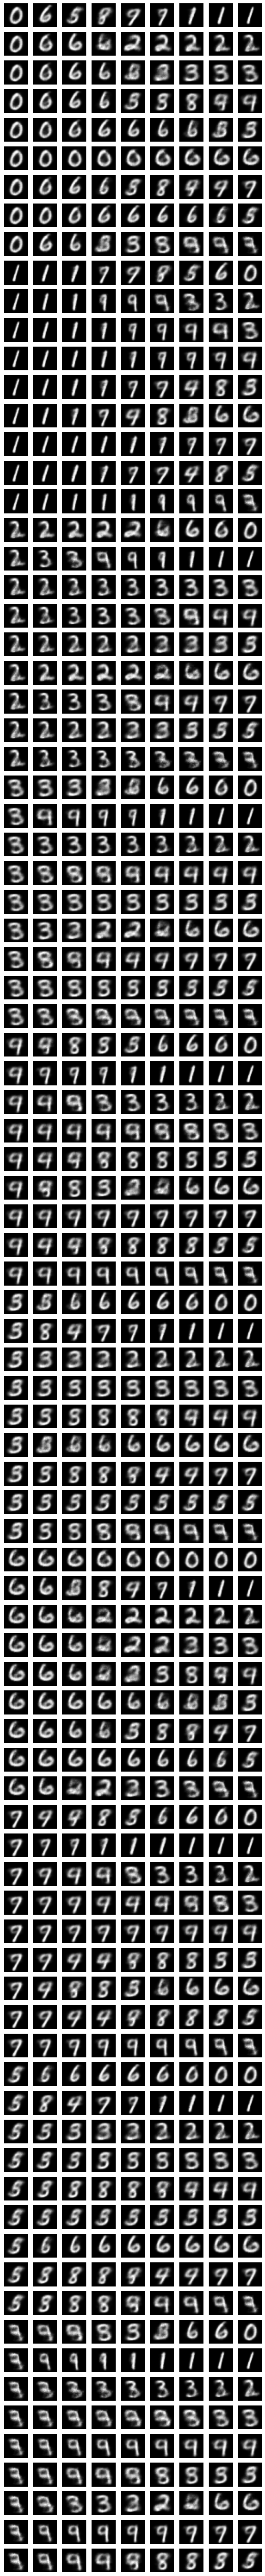

In [ ]:
def generate_different_digit_interpolations(test_dataset, vae, num_interpolations, device):
    different_digit_interpolations = []
    for digit1 in range(10):
        for digit2 in range(10):
            if digit1 != digit2:
                img1 = next(img for img, label in test_dataset if label == digit1)
                img2 = next(img for img, label in test_dataset if label == digit2)
                interpolations = interpolate_images(vae, img1, img2, num_interpolations, device)
                different_digit_interpolations.append(interpolations)
    return different_digit_interpolations

different_digit_interpolations = generate_different_digit_interpolations(test_dataset, vae, 9, device)
# Change the arguments to match the dimensions of different_digit_interpolations
visualize_interpolations(different_digit_interpolations, 90, 9)

Show 2D Latent Space
---------------------

20    20
recon image  torch.Size([400, 1, 28, 28])


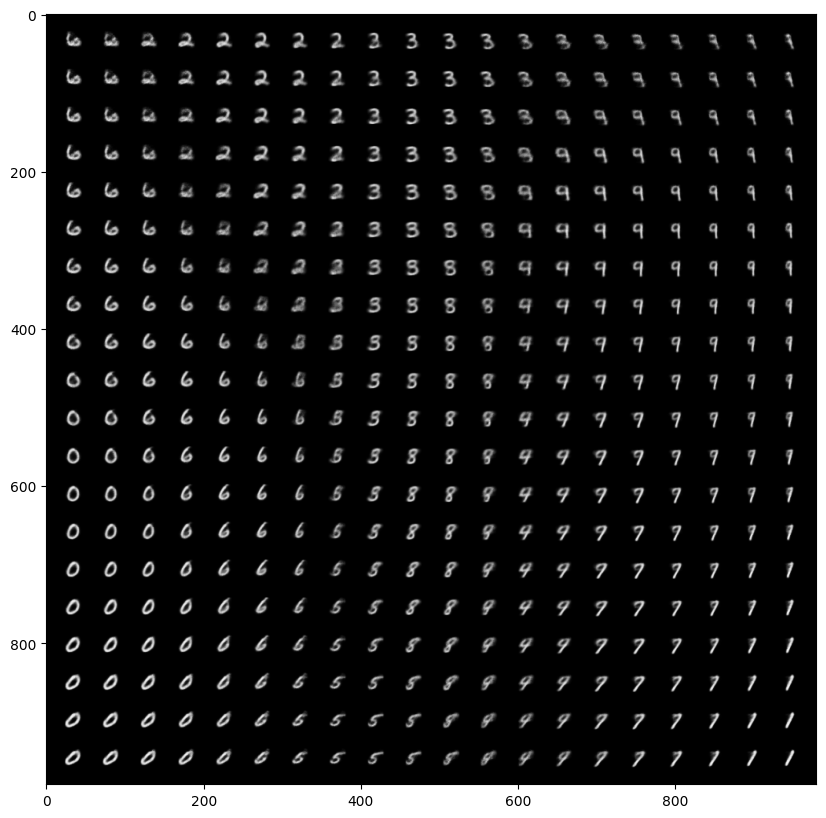

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    print(len(latent_x), "  ", len(latent_y))
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)

    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[i, j, 0] = lx
            latents[i, j, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    print("recon image ", image_recon.shape)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,20))
    plt.show()